In [515]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import boxcox
pd.options.display.max_rows = 50
pd.options.display.max_columns = 999
import warnings
warnings.filterwarnings('ignore')

In [516]:
def load_original_data():
    return pd.read_csv("Data_Marketing_Customer_Analysis_Round2.csv" )

In [517]:
ca_df=load_original_data()

In [518]:
ca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10910 entries, 0 to 10909
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     10910 non-null  int64  
 1   Customer                       10910 non-null  object 
 2   State                          10279 non-null  object 
 3   Customer Lifetime Value        10910 non-null  float64
 4   Response                       10279 non-null  object 
 5   Coverage                       10910 non-null  object 
 6   Education                      10910 non-null  object 
 7   Effective To Date              10910 non-null  object 
 8   EmploymentStatus               10910 non-null  object 
 9   Gender                         10910 non-null  object 
 10  Income                         10910 non-null  int64  
 11  Location Code                  10910 non-null  object 
 12  Marital Status                 10910 non-null 

In [519]:
ca_df['Policy'].value_counts()

Personal L3     4118
Personal L2     2537
Personal L1     1473
Corporate L3    1221
Corporate L2     688
Corporate L1     432
Special L2       193
Special L3       170
Special L1        78
Name: Policy, dtype: int64

In [520]:
# categorizing Policy
def policy_category(x):
    if x[0] == 'P':
        return 'Personal'
    elif x[0] == 'C':
        return 'Corporate'
    elif x[0] == 'S':
        return 'Special'
    
ca_df['Policy'] = list(map(policy_category, ca_df['Policy']))

In [521]:
# dropping the irrelevant columns
ca_df.drop(columns=['Unnamed: 0', 'Customer', 'Effective To Date', 'Policy Type', 'Vehicle Type'], inplace=True)

In [522]:
# replacing null values
ca_df['Months Since Last Claim'].fillna(value=round(ca_df['Months Since Last Claim'].mean(axis=0),0), inplace=True)
ca_df['Number of Open Complaints'].fillna(value=round(ca_df['Number of Open Complaints'].mean(axis=0),0), inplace=True)

In [523]:
# replacing 0 Income with mean
average_income = np.sum(ca_df['Income'])/np.count_nonzero(ca_df['Income'])
ca_df['Income'] = list(map(lambda x:x if x != 0 else average_income, ca_df['Income']))

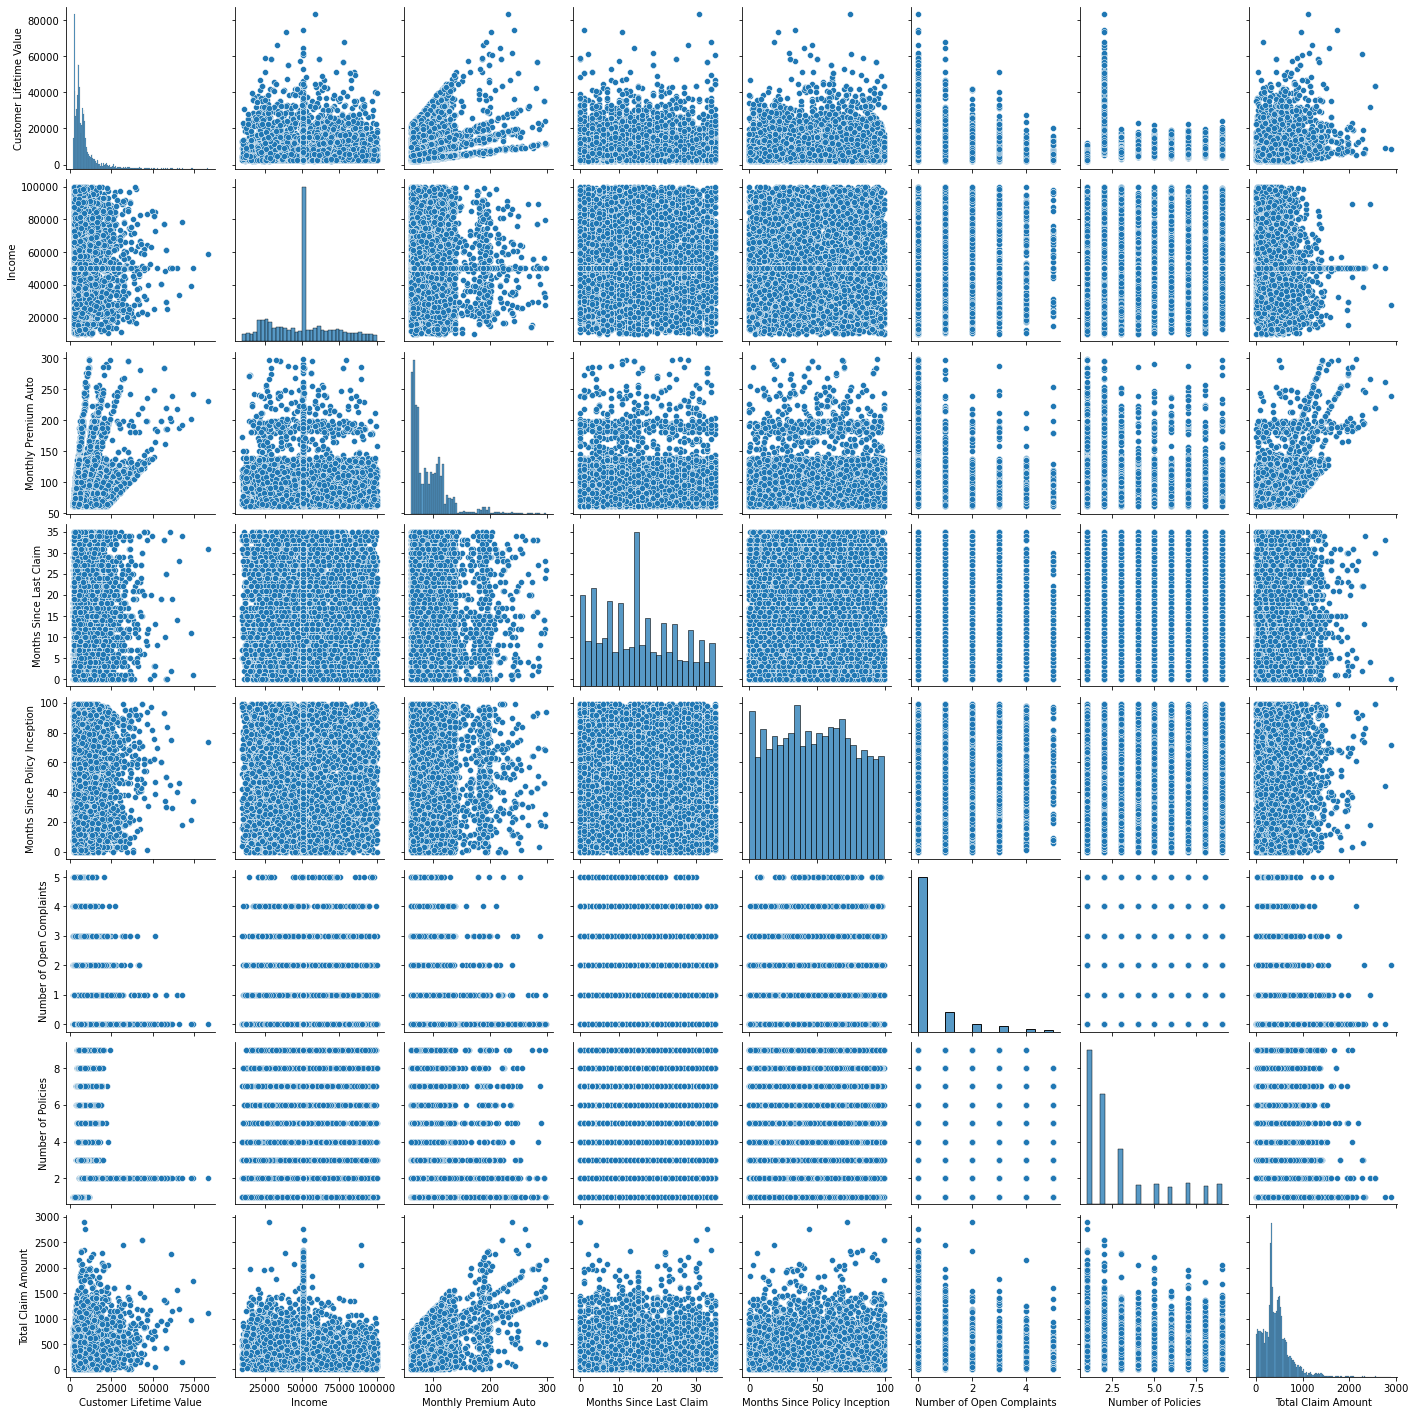

In [524]:
sns.pairplot(ca_df)

In [525]:
# removing outliners
## for Customer Lifetime Value
Q1 = ca_df['Customer Lifetime Value'].quantile(0.25)
Q3 = ca_df['Customer Lifetime Value'].quantile(0.75)
IQR = Q3 - Q1

In [526]:
clv_filter = (ca_df['Customer Lifetime Value'] >= Q1 - 1.5 * IQR) & (ca_df['Customer Lifetime Value'] <= Q3 + 1.5 * IQR)
ca_df = ca_df.loc[clv_filter]

In [527]:
# removing outliners
## for Monthly Premium Auto
Q1 = ca_df['Monthly Premium Auto'].quantile(0.25)
Q3 = ca_df['Monthly Premium Auto'].quantile(0.75)
IQR = Q3 - Q1

In [528]:
mpa_filter = (ca_df['Monthly Premium Auto'] >= Q1 - 1.5 * IQR) & (ca_df['Monthly Premium Auto'] <= Q3 + 1.5 * IQR)
ca_df = ca_df.loc[mpa_filter]

array([[<AxesSubplot:title={'center':'Customer Lifetime Value'}>,
        <AxesSubplot:title={'center':'Income'}>,
        <AxesSubplot:title={'center':'Monthly Premium Auto'}>],
       [<AxesSubplot:title={'center':'Months Since Last Claim'}>,
        <AxesSubplot:title={'center':'Months Since Policy Inception'}>,
        <AxesSubplot:title={'center':'Number of Open Complaints'}>],
       [<AxesSubplot:title={'center':'Number of Policies'}>,
        <AxesSubplot:title={'center':'Total Claim Amount'}>,
        <AxesSubplot:>]], dtype=object)

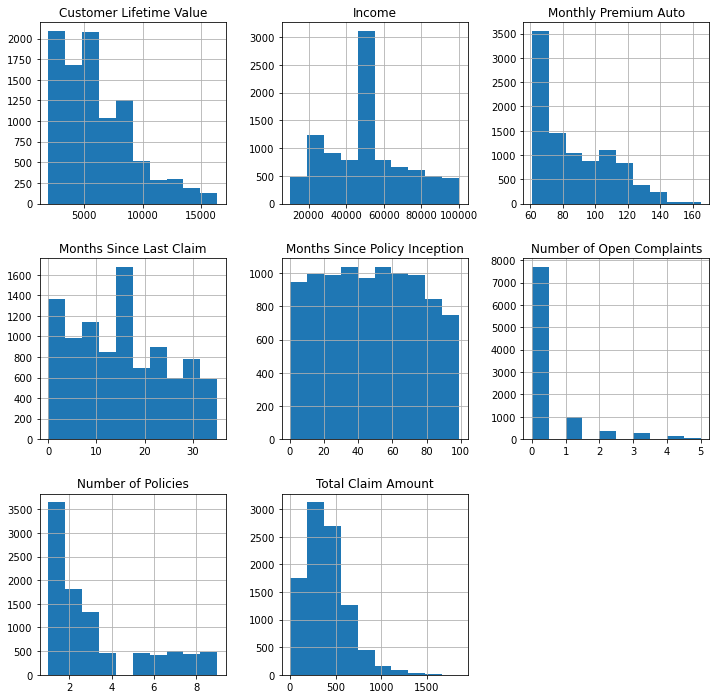

In [529]:
ca_df.hist(figsize = (12,12))

In [530]:
ca_df.corr()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
Customer Lifetime Value,1.000000,0.023686,0.425607,-0.018240,-0.011709,-0.029909,0.228867,0.167182
Income,0.023686,1.000000,0.001069,-0.026849,0.012654,0.008348,0.000671,-0.187133
Monthly Premium Auto,0.425607,0.001069,1.000000,-0.007587,0.000299,-0.019705,-0.011221,0.482923
Months Since Last Claim,-0.018240,-0.026849,-0.007587,1.000000,-0.043439,0.008574,0.004519,-0.007085
Months Since Policy Inception,-0.011709,0.012654,0.000299,-0.043439,1.000000,0.009346,-0.010966,-0.016639
Number of Open Complaints,-0.029909,0.008348,-0.019705,0.008574,0.009346,1.000000,0.001892,-0.011736
Number of Policies,0.228867,0.000671,-0.011221,0.004519,-0.010966,0.001892,1.000000,-0.006997
Total Claim Amount,0.167182,-0.187133,0.482923,-0.007085,-0.016639,-0.011736,-0.006997,1.000000


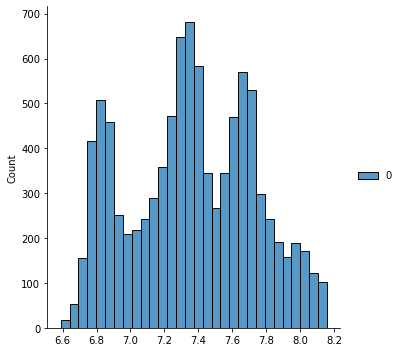

In [531]:
# transforming numericals
## for Customer Lifetime Value
Customer_Lifetime_Value_Transformed = PowerTransformer(standardize=False).fit_transform(ca_df['Customer Lifetime Value'].to_numpy().reshape(-1,1))
sns.displot(Customer_Lifetime_Value_Transformed)

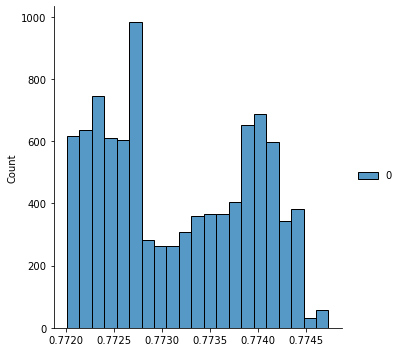

In [532]:
# transforming numericals
## for Monthly Premium Auto
Monthly_Premium_Auto_Transformed = PowerTransformer(standardize=False).fit_transform(ca_df['Monthly Premium Auto'].to_numpy().reshape(-1,1))
sns.displot(Monthly_Premium_Auto_Transformed)

In [533]:
# replacing the transformed numerical columns
ca_df['Customer Lifetime Value Transformed'] = Customer_Lifetime_Value_Transformed
ca_df['Monthly Premium Auto Transformed'] = Monthly_Premium_Auto_Transformed
ca_df.drop(columns = ['Customer Lifetime Value', 'Monthly Premium Auto'], axis=1, inplace=True)

In [534]:
# identifying categorical columns
categorical_features = ca_df.select_dtypes('object')
categorical_features

,State,Response,Coverage,Education,EmploymentStatus,Gender,Location Code,Marital Status,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size
0,Arizona,No,Basic,College,Employed,M,Suburban,Married,Corporate,Offer3,Agent,Four-Door Car,Medsize
1,California,No,Basic,College,Unemployed,F,Suburban,Single,Personal,Offer4,Call Center,Four-Door Car,Medsize
2,Washington,No,Basic,Bachelor,Employed,M,Suburban,Single,Personal,Offer3,Call Center,SUV,Medsize
4,Oregon,No,Premium,Bachelor,Medical Leave,F,Suburban,Married,Personal,Offer1,Branch,Four-Door Car,Medsize
5,NaN,NaN,Basic,High School or Below,Employed,M,Suburban,Divorced,Personal,Offer1,Agent,Four-Door Car,Medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10902,California,No,Extended,High School or Below,Employed,F,Suburban,Married,Personal,Offer2,Agent,Four-Door Car,Medsize
10903,Arizona,No,Basic,College,Employed,M,Suburban,Married,Personal,Offer2,Branch,Two-Door Car,Medsize
10906,Oregon,No,Basic,College,Employed,F,Urban,Married,Personal,Offer2,Branch,Four-Door Car,Medsize
10908,California,No,Premium,College,Employed,F,Urban,Divorced,Personal,Offer1,Branch,SUV,Medsize


In [535]:
ca_df['Education'].value_counts(dropna=False)

Bachelor                2871
College                 2844
High School or Below    2708
Master                   774
Doctor                   367
Name: Education, dtype: int64

In [536]:
ca_df['Coverage'].value_counts()

Basic       5953
Extended    2886
Premium      725
Name: Coverage, dtype: int64

In [537]:
# label encoding for Education
def education_label(x):
    if x == 'High School or Below':
        return 0
    elif x == 'College':
        return 1
    elif x == 'Bachelor':
        return 2
    elif x == 'Master':
        return 3
    elif x == 'Doctor':
        return 4

ca_df['Education Transformed'] = list(map(education_label, ca_df['Education']))

In [538]:
# label encoding for Coverage
def coverage_label(x):
    if x == 'Basic':
        return 0
    elif x == 'Extended':
        return 1
    elif x == 'Premium':
        return 2

ca_df['Coverage Transformed'] = list(map(coverage_label, ca_df['Coverage']))

In [539]:
# replacing the Education and Coverage column
ca_df.drop(columns=['Education', 'Coverage'], inplace=True)

In [540]:
# creating X-y split
X = ca_df.drop('Total Claim Amount', axis = 1)
y = ca_df['Total Claim Amount']

In [541]:
numericals = X._get_numeric_data()
numericals

,Income,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Customer Lifetime Value Transformed,Monthly Premium Auto Transformed,Education Transformed,Coverage Transformed
0,48029.000000,7.0,52,0.0,9,7.279993,0.772005,1,0
1,50414.978087,3.0,26,0.0,1,6.709618,0.772229,1,0
2,22139.000000,34.0,31,0.0,2,8.092073,0.773777,2,0
4,23675.000000,15.0,31,0.0,7,7.734936,0.774145,2,2
5,50549.000000,2.0,73,0.0,7,7.270190,0.772005,0,0
...,...,...,...,...,...,...,...,...,...
10902,28304.000000,10.0,30,2.0,1,7.062812,0.773518,0,1
10903,59855.000000,30.0,82,4.0,1,6.872983,0.772831,1,0
10906,61146.000000,7.0,68,0.0,6,7.345315,0.772299,1,0
10908,64195.000000,0.0,27,4.0,6,7.935754,0.774673,1,2


In [542]:
categoricals = X.select_dtypes('object')
categoricals

,State,Response,EmploymentStatus,Gender,Location Code,Marital Status,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size
0,Arizona,No,Employed,M,Suburban,Married,Corporate,Offer3,Agent,Four-Door Car,Medsize
1,California,No,Unemployed,F,Suburban,Single,Personal,Offer4,Call Center,Four-Door Car,Medsize
2,Washington,No,Employed,M,Suburban,Single,Personal,Offer3,Call Center,SUV,Medsize
4,Oregon,No,Medical Leave,F,Suburban,Married,Personal,Offer1,Branch,Four-Door Car,Medsize
5,NaN,NaN,Employed,M,Suburban,Divorced,Personal,Offer1,Agent,Four-Door Car,Medsize
...,...,...,...,...,...,...,...,...,...,...,...
10902,California,No,Employed,F,Suburban,Married,Personal,Offer2,Agent,Four-Door Car,Medsize
10903,Arizona,No,Employed,M,Suburban,Married,Personal,Offer2,Branch,Two-Door Car,Medsize
10906,Oregon,No,Employed,F,Urban,Married,Personal,Offer2,Branch,Four-Door Car,Medsize
10908,California,No,Employed,F,Urban,Divorced,Personal,Offer1,Branch,SUV,Medsize


In [543]:
# one hot encoding
categoricals = pd.get_dummies(categoricals, drop_first=True)

In [544]:
categoricals

,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_M,Location Code_Suburban,Location Code_Urban,Marital Status_Married,Marital Status_Single,Policy_Personal,Policy_Special,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small
0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0
2,0,0,0,1,0,1,0,0,0,1,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0
4,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0
5,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10902,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0
10903,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0
10906,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0
10908,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0


In [545]:
# combining the processed numerical and categorical columns
all_features = pd.concat([numericals, categoricals], axis=1)
all_features

,Income,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Customer Lifetime Value Transformed,Monthly Premium Auto Transformed,Education Transformed,Coverage Transformed,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_M,Location Code_Suburban,Location Code_Urban,Marital Status_Married,Marital Status_Single,Policy_Personal,Policy_Special,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small
0,48029.000000,7.0,52,0.0,9,7.279993,0.772005,1,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,50414.978087,3.0,26,0.0,1,6.709618,0.772229,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0
2,22139.000000,34.0,31,0.0,2,8.092073,0.773777,2,0,0,0,0,1,0,1,0,0,0,1,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0
4,23675.000000,15.0,31,0.0,7,7.734936,0.774145,2,2,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0
5,50549.000000,2.0,73,0.0,7,7.270190,0.772005,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10902,28304.000000,10.0,30,2.0,1,7.062812,0.773518,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0
10903,59855.000000,30.0,82,4.0,1,6.872983,0.772831,1,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0
10906,61146.000000,7.0,68,0.0,6,7.345315,0.772299,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0
10908,64195.000000,0.0,27,4.0,6,7.935754,0.774673,1,2,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0


In [546]:
X_train, X_test, y_train, y_test = train_test_split(all_features, y, test_size = 0.30, random_state = 100)

In [547]:
# standardizing the data
std_scaler = StandardScaler().fit(X_train) ## fit is to find the mean and variance of the train set
X_train_scaled = std_scaler.transform(X_train) ## transform to normal distribution after the splitting based on the train set

In [548]:
X_test_scaled = std_scaler.transform(X_test) ## Don't need to fit again as we need to apply the same mean and variance applied for fitting the X_train. Just to transofrm to normal distribution based on the test set

In [549]:
# applying linear regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [550]:
X.columns

Index(['State', 'Response', 'EmploymentStatus', 'Gender', 'Income',
       'Location Code', 'Marital Status', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Open Complaints',
       'Number of Policies', 'Policy', 'Renew Offer Type', 'Sales Channel',
       'Vehicle Class', 'Vehicle Size', 'Customer Lifetime Value Transformed',
       'Monthly Premium Auto Transformed', 'Education Transformed',
       'Coverage Transformed'],
      dtype='object')

In [551]:
model.coef_

array([-4.78090503e+00,  2.23515763e+00, -1.24513405e+00,  7.40740832e-01,
       -4.77824466e-01,  1.65938800e+00,  7.02173611e+01, -4.47629211e+00,
        1.70387691e+01,  2.52173484e+00, -4.66646142e-01,  1.10825810e+00,
        3.71308752e+00, -7.10326804e+00, -5.52247006e-01,  3.12126904e+00,
        1.36505251e+00,  3.23692898e+01,  5.14524789e+00,  1.72702019e+02,
        8.01262496e+01, -7.27919414e-01,  2.70029933e+01,  2.41729462e+00,
        2.24292242e+00,  5.87189802e+00,  2.86044211e+00,  8.06541517e-01,
       -7.04309768e-01,  1.65973061e+00,  1.82140731e-02,  2.81018039e+01,
        1.62226859e+01, -9.81080709e-01, -3.18101714e+00,  2.70469401e+00])

In [552]:
model.intercept_

398.22564621123723

In [553]:
model.score(X_test_scaled, y_test)

0.733154719200287

In [554]:
# checking the model prediction
y_pred = model.predict(X_test_scaled)

In [555]:
y_test

6574      80.705050
7141      73.700573
7868     312.000000
5601     792.868448
8795     452.915621
            ...    
5875     611.476898
5351     256.438030
10438    430.505942
5246      65.471028
9829     178.371281
Name: Total Claim Amount, Length: 2870, dtype: float64

In [556]:
y_pred

array([289.59984349, 266.53367748, 337.94307792, ..., 631.45343897,
         2.62297477,  87.79885742])

In [557]:
result = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

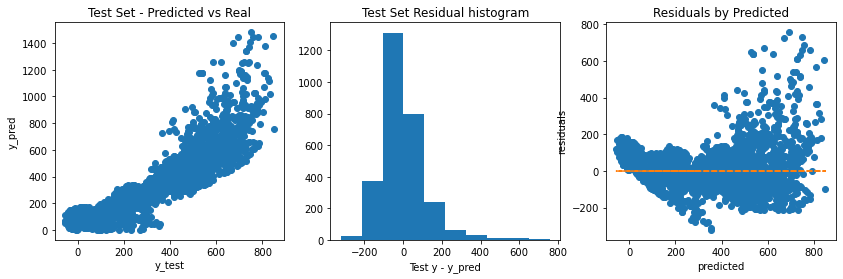

In [558]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set - Predicted vs Real")

ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y - y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred, y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

In [559]:
# MSE
MSE = mse(y_test, y_pred)
MSE

14769.30405925506

In [560]:
# RMSE
RMSE = np.sqrt(MSE)
RMSE

121.52902558341798

In [561]:
# MAE
MAE = mae(y_test, y_pred)
MAE

86.5085652043253

In [562]:
R2 = r2_score(y_test, y_pred)
R2

0.733154719200287

In [563]:
Adj_R2 = 1-((1-R2)*(len(y_test)-1)/((len(y_test)-X_test.shape[1]-1)))
Adj_R2

0.7297638155261643

In [564]:
features_importance = pd.DataFrame(data = {
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)
})
features_importance = features_importance.sort_values(by='Importance', ascending=False)

In [565]:
features_importance

,Attribute,Importance
19,Location Code_Suburban,172.702019
20,Location Code_Urban,80.126250
6,Monthly Premium Auto Transformed,70.217361
17,EmploymentStatus_Unemployed,32.369290
31,Vehicle Class_SUV,28.101804
22,Marital Status_Single,27.002993
8,Coverage Transformed,17.038769
32,Vehicle Class_Sports Car,16.222686
13,Response_Yes,7.103268
25,Renew Offer Type_Offer2,5.871898
